# Run IZI <a class="tocSkip">

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pnlf.packages import *

from pnlf.constants import tab10, single_column, two_column
from pnlf.plot import quick_plot, add_scale

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
logging.basicConfig(stream=sys.stdout,datefmt='%H:%M:%S',level=logging.INFO)
logger = logging.getLogger(__name__)

basedir = Path('..')  # where we save stuff (and )
data_ext = Path('a:') # raw data

# we use the sample table for basic galaxy properties
sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('Name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])

## Read in data

the galaxies listed in `hst_sample` have a cluster catalogue. The galaxies listed in `muse_sample` have astrosat observations to measure the FUV.

### MUSE (DAP + nebulae catalogues)

In [3]:
name = 'NGC1672'

from pnlf.auxiliary import filter_table
from pnlf.io import ReadLineMaps

p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# DAP linemaps (Halpha and OIII)
filename = data_ext / 'MUSE_DR2' / 'MUSEDAP' / f'{name}_MAPS.fits'
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                    mask=np.isnan(hdul['OIII5006_FLUX'].data),
                    meta=hdul['OIII5006_FLUX'].header,
                    wcs=WCS(hdul['OIII5006_FLUX'].header)) 

    
# nebulae catalogue from Francesco (mostly HII-regions)
filename = basedir / 'data' / 'interim' / f'Nebulae_Catalogue_with_FUV_DR2.fits'
with fits.open(filename) as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg)
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])
nebulae.add_index('region_ID')

with np.errstate(divide='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    nebulae['HA/FUV_err'] = nebulae['HA/FUV']*np.sqrt((nebulae['HA6562_FLUX_CORR_ERR']/nebulae['HA6562_FLUX_CORR'])**2+(nebulae['FUV_FLUX_CORR_ERR']/nebulae['FUV_FLUX_CORR'])**2)

HII_regions = filter_table(nebulae,gal_name=name,BPT_NII=0,BPT_SII=0,BPT_OI=0)
nebulae = filter_table(nebulae,gal_name=name)

filename = data_ext / 'MUSE_DR2' / 'Nebulae catalogue' /'spatial_masks'/f'{name}_HIIreg_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data-1,mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

# WFI image (larger FOV)
filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
with fits.open(filename) as hdul:
    WFI = NDData(data=hdul[0].data,
                 meta=hdul[0].header,
                 wcs=WCS(hdul[0].header))
    
print(f'{name}: {len(HII_regions)} HII-regions in final catalogue')

NGC1672: 1040 HII-regions in final catalogue


C:\Users\fabian\miniconda3\envs\pymuse\lib\site-packages\astropy\table\column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


## IZI

### Standard version

In [4]:
from izi.izi import izi

joint Z, q 8.695092028501083 7.1938775510204085
mode Z (8.695092, + 0.081633, - 0.040816), q (7.234694, + 0.122449, - 0.081633)
mean Z, (8.738605, + 0.038120, - 0.084329), q (7.271266, + 0.085877, - 0.118204)
test
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.


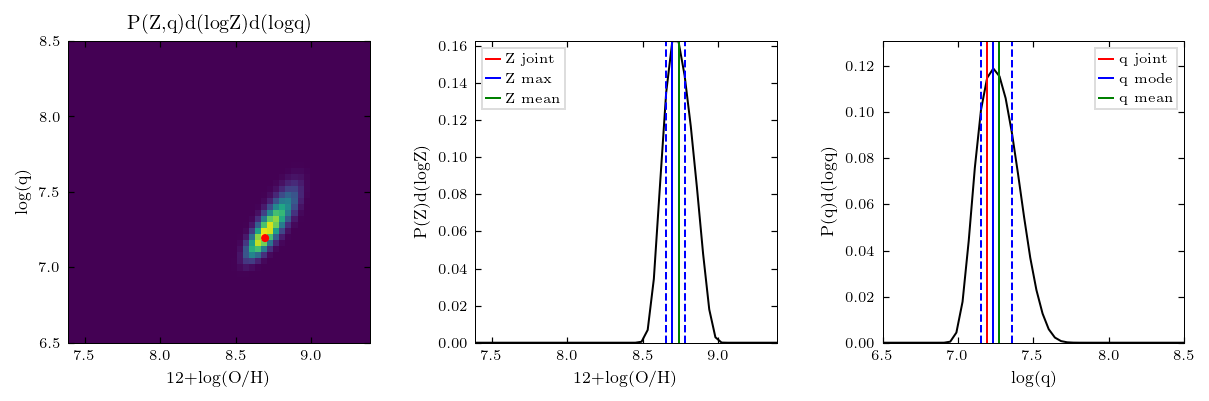

In [5]:
flux=[3.44,2.286, 1, 0.553, 0.698, 2.83]
error=[0.17, 0.07,0.05, 0.023, 0.027, 0.15]
ID=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' , 'nii6548;nii6584', \
       'sii6717;sii6731', 'halpha']
   
out2=izi(flux, error, ID,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

In [ ]:
flux=[3.44,2.286, 1]
error=[0.17, 0.07,0.05]
id=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' ]
   
out2=izi(flux, error, id,\
    intergridfile='interpolgrid_50_50d13_kappa20',
    epsilon=0.1, quiet=False, plot=True)

### IZI MCMC

In [ ]:
from izi.izi_MCMC import izi_MCMC

In [ ]:
flux=[3.44,2.286, 1, 0.553, 0.698, 2.83]
error=[0.17, 0.07,0.05, 0.023, 0.027, 0.15]
id=['oii3726;oii3729','oiii4959;oiii5007', 'hbeta' , 'nii6548;nii6584', \
       'sii6717;sii6731', 'halpha']

out2=izi_MCMC(flux, error, id,\
     intergridfile='interpolgrid_100_100d13_kappaINF', epsilon=0.1, quiet=False, 
     plot=True,plot_z_steps=False,plot_q_steps=False,
     logqprior=None)

### Use on nebulae catalogues

In [ ]:
names = {
 'HB4861':'hbeta',
 'OIII5006':'oiii5007',
 'HA6562':'halpha',
 'NII6583':'nii6584',
 'SII6716':'sii6717',
 'SII6730':'sii6731',
 'SIII9068':'siii9068',
 'OI6300':'oi6300',
 'NII5754':'nii5755',
 'HEI5875':'hei5875',
 'SIII6312':'siii6312',
 'OII7319':'oii7318',
}

all_lines = ['HB4861','OIII5006','NII5754','OI6300','SIII6312',
             'HA6562','NII6583','SII6716','SII6730','OII7319','SIII9068']
small = ['HB4861','OIII5006','HA6562','NII6583','SII6716','SII6730','SIII9068']

lines = small

In [ ]:
ID    = [names[line] for line in lines]

for num in range(5):
    flux  = np.array(list(nebulae[[line+'_FLUX_CORR' for line in lines]][num]))
    error = np.array(list(nebulae[[line+'_FLUX_CORR_ERR' for line in lines]][num]))

    out=izi(flux,error, ID,plot=False,quiet=True)
    print(f'NC: Z={nebulae["Z"][num]:.2f} vs IZI: Z={out.sol["Z_joint"]:.2f}')

In [ ]:
ID = [names[line] for line in lines]

for num in range(5):

    flux  = np.array(list(nebulae[[line+'_FLUX' for line in lines]][num]))
    error = np.array(list(nebulae[[line+'_FLUX_ERR' for line in lines]][num]))
    
    out_mcmc = izi_MCMC(flux,error,ID,plot=False,quiet=True)
    print(f'NC: Z={nebulae["Z"][num]:.2f} vs IZI: Z={out_mcmc.sol["Z"]:.2f}')